# Spam Classifier

Data sets used for training and testing in this classifier is taken from https://kaggle.com/c/adcg-ss14-challenge-02-spam-mails-detection/

### Architecture
The architecture for the spam classifier is as follows :
- **Data Loading**   
   Classes in this section are used to load data from file into the memory. Data Loading also includes classes to contain the data
  - `MailData` class for containing the data for payload and body
  - `MailDataLoader` class for loading the class
- **Preprocessing and Feature Extraction**   
  Classes used in this part is to load, preprocess, and extract features from classes. The main use is to make the data available for. The preprocessor contains the following class
  - `Preprocessor` class for preprocessing data, including tokenization, stemming, stripping HTML tags and also removing stopwords. **NLTK** library is used in this part for stemming, tokenization and removing stopwords.
  Feature extraction and selection is done by using TF-IDF
- **Training**   
   Classes in this section are used to train the data for creating the model to further predict new data. The training parts contains the following class :
   - `Trainer` class for training data using the provided classifier. Training is used with classifier from **scikit-learn** library. Classifiers used are MLP, SVC, and NaiveBayes
   
### Scenarios
Training are done in the following ways :
1. Loading the training data with the `MailDataLoader` class
2. Preprocessing data (tokenization, stemming, removing stopwords)
3. Extracting features with `CountVectorizer` to be changed into TF-IDF with scikit. Features are used if the features is within a minimum of 25 documents 
4. Training the data with classifiers

### Results
Through the training, the accuracy value of ____% was achieved.

### Analysis of Results
Incorrect classification results are made because of unclean training data. Most of the email data are in a many different format. Emails in training data are written in formats such as multiparts, PGP secured, and other formats. Parsing the format of these emails are a challenge since there are widely different formats of email. Thus, affecting the cleanliness of data and tokens used in tokenizations.

## 1. Data and Data Loading

In [1]:
import HTMLStripper
import os, csv
import ast

In [2]:
class MailData:
    def __init__(self, subject, body, label=None):
        self.payload = str(subject) + " " + str(body)
        self.label = label        

In [3]:
class MailDataLoader:
    __trainingPath = "data/TR"
    __testingPath = "data/TT"
    __trainingLabel = "spam-mail.tr.label"

    def __loadFolder(self, folderName):
        if os.path.exists(folderName):
            files = os.listdir(folderName)
            mailData = []
            for file in files:
                srcpath = os.path.join(folderName, file)

                mailFile = open(srcpath,"r")
                mail = ast.literal_eval(mailFile.read())
                mailData.append(MailData(mail["subject"],mail["body"]))
                mailFile.close()
        else:
            raise ValueError("Folder does not exist")
        return mailData

    def loadTraining(self):
        trainingData = self.__loadFolder(self.__trainingPath)
        labels = list(csv.reader(open(self.__trainingLabel,"r")))
        
        for label in labels:
            if(label[0] != 'Id'):
                trainingData[int(label[0])-1].label = bool(int(label[1]))
            
        return trainingData

    def loadTesting(self):
        return self.__loadFolder(self.__trainingPath)

## 2. Preprocessing

In [4]:
import sklearn.feature_extraction.text
from nltk.tokenize import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [5]:
class Preprocessor:
    # Constants
    minimalFreq = 25
    maximalFreq = 2500

    def preprocessData(self, data):
        messages = [self.__processText(d) for d in data]
        
        vector = CountVectorizer(stop_words = None, min_df=self.minimalFreq, max_df=self.maximalFreq, token_pattern=r'[A-Za-z]+')        
        train_count = vector.fit_transform(messages)
        
        transformer = sklearn.feature_extraction.text.TfidfTransformer()
        train_tf = transformer.fit_transform(train_count)
        
        return vector, train_tf, messages
        

    def __processText(self, text, use_tokenize=True, use_stopwords=True, use_stemmer=True):
        # Lowercase
        text = text.lower()

        # Tokenize
        if(use_tokenize):
            token = word_tokenize(text)
            token = [t for t in token if len(t) >= 3]
            
        # Remove Stopwords
        if(use_stopwords):
            stops = stopwords.words('english')
            newsw = ['one','will', 'new', 'n\'t', 'use', 'unsubscribe', 'subscribe']
            stops.extend(newsw)
            token = [t for t in token if t not in stops]
        
        # Stemmer
        if(use_stemmer):
            lemma = WordNetLemmatizer()
            token = [lemma.lemmatize(t) for t in token]
            
        if(use_tokenize):
            text = ' '.join(token)
        return text

## 3. Training

In [6]:
import HTMLStripper
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from wordcloud import WordCloud

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
class Trainer:
    # Constants
    test_size = 0.2

    def __init__(self, classifier):
        self.classifier = classifier

    def train(self, mailDataList):
        preprocessor = Preprocessor()
        
        payloads = []
        label = []
        for mailData in mailDataList:
            text = HTMLStripper.stripTags(mailData.payload)
            text = HTMLStripper.cleanText(text)
            payloads.append(text)
            label.append(mailData.label)
        
        self.vector, dataset, messages = preprocessor.preprocessData(payloads)
        
        message = ''
        for m in messages:
            message += m
        
        self.token = word_tokenize(message)
        
        self.__trainModel(dataset, label)
            
    def __trainModel(self, data, label):
        
        data = data.toarray()
        
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=self.test_size, random_state=0,shuffle=True)
        
        self.classifier.fit(X_train, y_train)
        
        y_pred = self.classifier.predict(X_test)
        print('Accuracy : %5.3f' % float(self.classifier.score(X_test, y_test)*100))
        print(confusion_matrix(y_test, y_pred))
    
    def getVectorCount(self):
        return self.vector

In [8]:
data = MailDataLoader().loadTraining()
#classifier = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(300, 10), random_state=1)
#classifier = KNeighborsClassifier(n_neighbors=50)
#classifier = svm.SVC()
#classifier = GaussianNB(priors=[0.7,0.3])
classifier = RandomForestClassifier()

trainer = Trainer(classifier)
trainer.train(data)
print('Feature count :', len(trainer.getVectorCount().get_feature_names()))
print(trainer.getVectorCount().get_feature_names())

Accuracy : 61.200
[[ 35 112]
 [ 82 271]]
Feature count : 1974
['a', 'ability', 'able', 'absolutely', 'accept', 'accepted', 'access', 'according', 'account', 'achieve', 'across', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'ad', 'adam', 'add', 'added', 'adding', 'addition', 'additional', 'address', 'admin', 'administration', 'administrator', 'adobe', 'advance', 'advanced', 'advantage', 'advertise', 'advertising', 'advice', 'affect', 'africa', 'age', 'agency', 'agent', 'ago', 'agree', 'aim', 'air', 'al', 'alert', 'alexander', 'all', 'allow', 'allowed', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'alternative', 'although', 'always', 'am', 'america', 'american', 'among', 'amount', 'and', 'animal', 'announcement', 'another', 'answer', 'anti', 'anybody', 'anymore', 'anyone', 'anything', 'anyway', 'anywhere', 'aol', 'api', 'apology', 'app', 'apparently', 'appear', 'appears', 'apple', 'application', 'applied', 'apply', 'appreciate', 'approach', 'appropriate', 'app

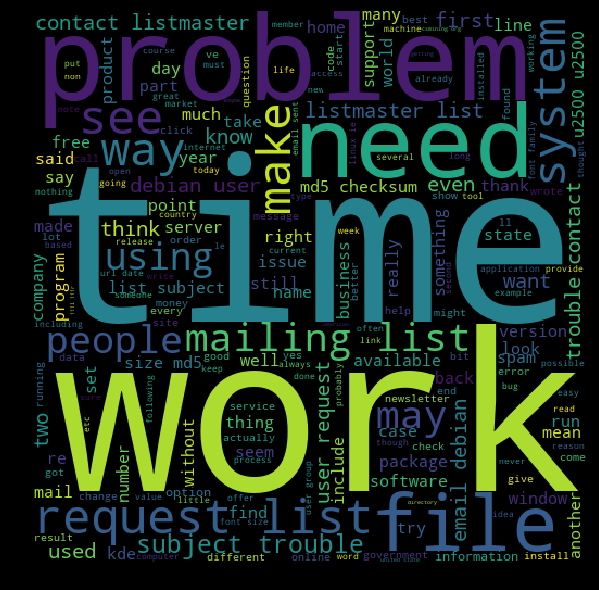

In [9]:
spam_words = ' '.join(trainer.token)
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()